In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as spi
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
filename = 'data/diff_lambdas_step2.csv'
df = pd.read_csv(filename)
df.head()

,DL,DLS,DS,numerical_thetas,om_lambdas,rs,rs_initial,step,theta
0,196.760858,22.460452,218.106508,0.00001,0.000000,230.316756,230.318417,5.000000e-07,0.00001
1,196.899124,22.493099,218.286972,0.00001,0.020204,230.495156,230.498050,5.000000e-07,0.00001
2,197.037776,22.525820,218.452309,0.00001,0.040408,230.675930,230.678239,5.000000e-07,0.00001
3,197.176816,22.558834,218.619550,0.00001,0.060612,230.857272,230.858988,5.000000e-07,0.00001
4,197.316245,22.591814,218.786507,0.00001,0.080816,231.039066,231.040298,5.000000e-07,0.00001


In [3]:
# patch
length_scale = 3.086e22
H_0 = 7.56e-27 * length_scale
M = 1474e12 / length_scale

z_lens1 = np.linspace(0.05, 0.2, 100)
z_lens2 = []
for z in z_lens1:
    z_lens2.extend([z]*50)

# print(len(z_lens2), len(df.index))
df['z_lens'] = z_lens2[:len(df.index)]

def get_distances(z, Omega_Lambda=0):
    Omega_m = 1 - Omega_Lambda
    def integrand(z):
        return 1/np.sqrt(Omega_m*(1+z)**3 + Omega_Lambda)
    integral, error = spi.quad(integrand, 0, z)
    comoving = integral/H_0
    dang = comoving/(1+z)
    return comoving, dang

dang_lens = []
for index, row in df.iterrows():
    com, dang = get_distances(row.z_lens, row.om_lambdas)
    dang_lens.append(dang)

df['DL'] = dang_lens

In [4]:
# df = df[~((df.om_lambdas < 0.707144) & (df.om_lambdas > 0.707142))]

length_scale = 3.086e22
H_0 = 7.56e-27 * length_scale
M = 1474e12 / length_scale

def calc_theta(D_LS, D_L, D_S):
    return np.sqrt(4*M*D_LS/D_L/D_S)

theta_second_order = []
theta_rindler = []
for index, row in df.iterrows():
    Lambda = 3*row.om_lambdas*H_0**2
    coeff = [row.DLS*Lambda*row.DL**3/6/M, row.DS, -4*M*row.DLS/row.DL, 8*M**3*row.DLS]
    roots = np.roots(coeff)
    roots = roots[roots>0]
    th = np.sqrt(roots)
    rindler = th[np.argmin(row.theta - th)]
    
    coeff2 = [row.DS, -4*M*row.DLS/row.DL, 8*M**3*row.DLS]
    roots2 = np.roots(coeff2)
    roots2 = roots2[roots2>0]
    th2 = np.sqrt(roots2)
    second_order = th2[np.argmin(row.theta - th2)]
    theta_rindler.append(rindler)
    theta_second_order.append(second_order)

df['theta_second_order'] = theta_second_order
df['theta_rindler'] = theta_rindler


## removed percentage!!

df['percentage_diff'] = (df.numerical_thetas - df.theta)/df.theta
df['rindler_preds'] = (df.theta_rindler - df.theta)/df.theta
# df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta*100
# df['percentage_diff'] = (df.rs - df.rs_initial)/df.rs_initial*100

In [5]:
df.head()

,DL,DLS,DS,numerical_thetas,om_lambdas,rs,rs_initial,step,theta,z_lens,theta_second_order,theta_rindler,percentage_diff,rindler_preds
0,196.760858,22.460452,218.106508,0.00001,0.000000,230.316756,230.318417,5.000000e-07,0.00001,0.05,0.00001,0.00001,-0.000031,-0.004572
1,196.899124,22.493099,218.286972,0.00001,0.020204,230.495156,230.498050,5.000000e-07,0.00001,0.05,0.00001,0.00001,-0.000055,-0.004599
2,197.037776,22.525820,218.452309,0.00001,0.040408,230.675930,230.678239,5.000000e-07,0.00001,0.05,0.00001,0.00001,-0.000044,-0.004592
3,197.176816,22.558834,218.619550,0.00001,0.060612,230.857272,230.858988,5.000000e-07,0.00001,0.05,0.00001,0.00001,-0.000032,-0.004584
4,197.316245,22.591814,218.786507,0.00001,0.080816,231.039066,231.040298,5.000000e-07,0.00001,0.05,0.00001,0.00001,-0.000023,-0.004579


In [6]:
stats = df[['om_lambdas', 'percentage_diff', 'rindler_preds']].groupby('om_lambdas').agg(['mean', 'std', 'count'])
stats.columns = [' '.join(col).strip() for col in stats.columns.values]
stats['percentage_diff mean std'] = stats['percentage_diff std']/np.sqrt(stats['percentage_diff count'])
stats

,percentage_diff mean,percentage_diff std,percentage_diff count,rindler_preds mean,rindler_preds std,rindler_preds count,percentage_diff mean std
om_lambdas,,,,,,,
0.000000,-0.000007,0.000048,100,-0.010017,0.002974,100,0.000005
0.020204,-0.000012,0.000047,100,-0.010057,0.003002,100,0.000005
0.040408,-0.000013,0.000046,100,-0.010093,0.003018,100,0.000005
0.060612,-0.000009,0.000044,100,-0.010124,0.003045,100,0.000004
0.080816,-0.000007,0.000042,100,-0.010158,0.003077,100,0.000004
0.101020,-0.000016,0.000044,100,-0.010203,0.003095,100,0.000004
0.121224,-0.000007,0.000047,100,-0.010230,0.003121,100,0.000005
0.141429,-0.000004,0.000045,100,-0.010264,0.003143,100,0.000005
0.161633,-0.000012,0.000042,100,-0.010310,0.003178,100,0.000004


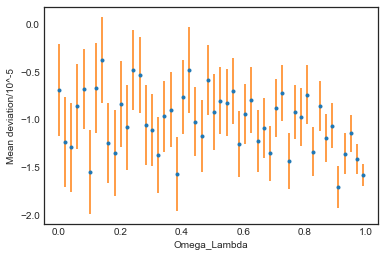

In [7]:
scale = 1e-5
plt.plot(stats.index, stats['percentage_diff mean']/scale, '.')
plt.errorbar(stats.index, stats['percentage_diff mean']/scale, yerr=stats['percentage_diff mean std']/scale, linestyle='none')
plt.xlabel('Omega_Lambda')
plt.ylabel('Mean deviation/10^-5')
# plt.plot(stats.index, stats['rindler_preds mean'])